In [29]:
# Variables

UID = 'ppossemiers' # user id of authenticated github user
PWD = 'ikhebeennieuwPasw00rd' # password of authenticated github user
USER = 'hibernate' # github user of the repo under investigation
BASE_PATH = '../data/analyzer/' # local expansion path
#REPO = 'netty-4.1'
REPO = 'hibernate-orm' # repo to investigate
STOP_LINES = ['*', '//', 'import', 'package', '{', '}', '@'] # lines to remove from code (comments, imports, ...)
STOP_WORDS = ['abstract','continue','for','new','switch','assert','default','goto','synchronized',
            'boolean','do','if','private','this','break','double','implements','protected','throw',
            'byte','else','public','throws','case','enum','instanceof','return','transient',
            'catch','extends','int','short','try','char','final','interface','static','void',
            'class','finally','long','strictfp','volatile','const','float','native','super','while'
            'true','false','null']

In [34]:
# Imports and directives

%matplotlib inline
from pyspark import SparkContext
import numpy as np
import os, re, requests, zipfile, json, operator
from StringIO import StringIO
from pyspark.ml.feature import Tokenizer, RegexTokenizer, HashingTF, IDF
import matplotlib.pyplot as plt
from requests.auth import HTTPBasicAuth
from collections import Counter

In [ ]:
# Utility functions

def all_files(directory):
    for path, dirs, files in os.walk(directory):
        for f in files:
            yield os.path.join(path, f)

def sanitize(contents):
    lines = contents.split('\n')

    # remove stop lines
    for stop_line in STOP_LINES:
        lines = [line.lower().lstrip().replace(';', '') for line in lines if stop_line not in line and line <> '']

    # remove stop words
    for stop_word in STOP_WORDS:
        # replace() doesn't work because variables get mangled
        lines = [re.sub(r'\b%s\b' % stop_word, '', line) for line in lines]
    
    # remove operators
    lines = [line.replace('=', '').replace('+', '')
             .replace('-', '').replace('>', '')
             .replace('<', '').replace('|', '')
             .replace('%', '') for line in lines]
    
    # join all lines into one string
    return ' '.join(lines)

def count_dependencies(src):
    names, codes = zip(*src)
    deps = {e : 0 for i, e in enumerate(names)}

    for name in names:
        for code in codes:
            if name in code:
                deps[name] += 1
    
    # sort by amount of references
    #return sorted(deps.items(), key=operator.itemgetter(1), reverse=True)
    return {k: v for k, v in deps.iteritems() if v > 1}

def make_hbar_plot(dictionary, title, x_label):
    # show top referenced classes
    refs = sorted(dictionary.values(), reverse=True)[:25]
    lbls = sorted(dictionary, key=deps.get, reverse=True)[:25]

    # make plot
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle(title, fontsize=15)
    ax = fig.add_subplot(111)

    #set ticks
    y_pos = np.arange(len(lbls)) + 0.5
    ax.barh(y_pos, refs, align='center', alpha=0.4, color='darksalmon')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(lbls)
    ax.set_xlabel(x_label)

    plt.show()
    pass

## Commit frequency

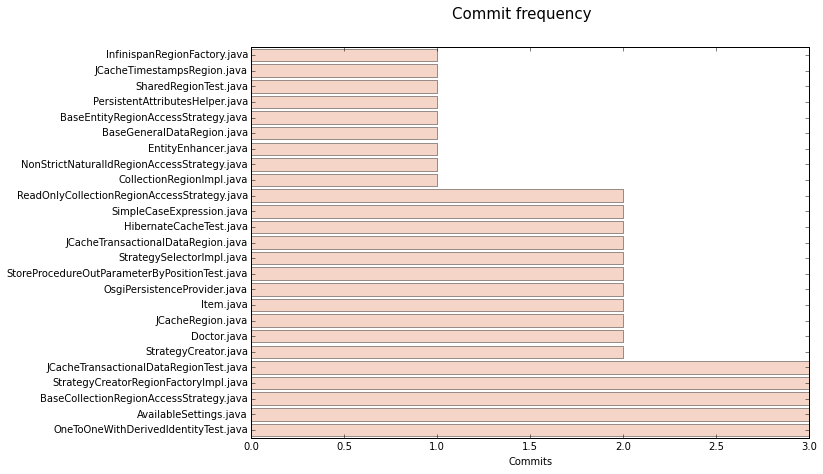

In [48]:
repo_url = 'https://github.com/' + USER + '/' + REPO + '/archive/master.zip'
dir_name = BASE_PATH + REPO + '/'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

    zip = requests.get(repo_url)
    if zip.ok:
        zipdata = StringIO()
        zipdata.write(zip.content)

        with zipfile.ZipFile(zipdata, 'r') as z:
            z.extractall(dir_name)
    
commits = []
stats = requests.get('https://api.github.com/repos/' + USER + '/' + REPO 
                                     + '/commits', auth=HTTPBasicAuth(UID, PWD))

if stats.ok:
    stats_json = json.loads(stats.text or stats.content)
    for commit in stats_json:
        try:
            sha = requests.get('https://api.github.com/repos/' + USER + '/' + REPO 
                                    + '/commits/' + commit['sha'], auth=HTTPBasicAuth(UID, PWD))
            if sha.ok:
                files_json = json.loads(sha.text or sha.content)
                for f in files_json['files']:
                    file_name = f['filename'][f['filename'].rfind('/') + 1:]
                    if file_name.endswith('.java'):
                        commits.append(file_name)
        except:
            print 'No key present'
            
commit_dict = dict((x, commits.count(x)) for x in set(commits))
make_hbar_plot(commit_dict, 'Commit frequency', 'Commits')

## Class reference count

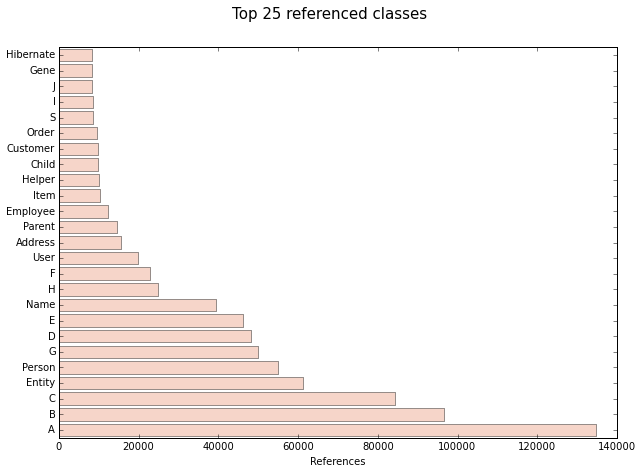

In [46]:
joined = []
# get all java source files
src_files = [f for f in all_files(BASE_PATH + REPO) if f.endswith('.java')]

for n in src_files:
    # create tuple of classname and contents of file
    # plain read is used to avoid broadcasting the spark context
    joined.append((os.path.basename(n).split('.')[0], open(n, 'r').read()))

deps = count_dependencies(joined)
make_hbar_plot(deps, 'Top 25 referenced classes', 'References')

In [ ]:
joined_rdd = sc.parallelize(joined)
# make tuple of (class_name, sanitized code) for each source file
sanitized = joined_rdd.map(lambda tup: (tup[0], sanitize(tup[1])))

sanitized_df = sqlContext.createDataFrame(sanitized, ['label', 'code'])
tokenizer = Tokenizer(inputCol='code', outputCol='words')
words_df = tokenizer.transform(sanitized_df)

#for words_label in words_df.select('words', 'label').take(2):
#    print(words_label)

hashingTF = HashingTF(inputCol='words', outputCol='rawFeatures', numFeatures=5)
featurizedData = hashingTF.transform(words_df)

idf = IDF(inputCol='rawFeatures', outputCol='features')
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

for features_label in rescaledData.select('features', 'label').take(3):
    print(features_label)